# Read Me

This notebook aims to implement Minimum Variance portfolio optimization to construct portfolios with currency pairs. Note that this is all done on spot returns not total returns (which would account for interest rate differences between the countries as well as exchange rates). Portfolio-level variance is given by the below formula and we minimize for this (here each w_i is a weight and each r_i is a return of an individual asset). This formula can be neatly expressed as a quadratic form so we use the quadratic form when optimizing.

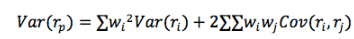


# Imports

In [1]:
%pip install cvxpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import cvxpy as cp
import numpy as np
import math

(CVXPY) Aug 06 04:08:53 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Version of ortools (9.4.1874) is too old. Expected >= 9.5.0.')
(CVXPY) Aug 06 04:08:53 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Version of ortools (9.4.1874) is too old. Expected >= 9.7.0.')


# Get Data

In [3]:
# Read data
df = pd.read_csv(
    filepath_or_buffer="/kaggle/input/ibm-unsupervised-learning-eda-and-data-cleaning/data.csv",
    index_col='Date',
    parse_dates=['Date']
)

In [4]:
df.head(5)

,USD/AUD,USD/BRL,USD/CAD,USD/EUR,USD/INR,USD/JPY,USD/MXN,USD/ZAR,USD/KRW,USD/GBP,USD/CHF,USD/SEK,USD/NOK,USD/NZD,USD/CZK,USD/HUF,USD/PLN
Date,,,,,,,,,,,,,,,,,
2009-01-02 00:00:00+00:00,1.4098,2.3130,1.2094,0.71824,48.244999,91.790001,13.7750,9.2800,1322.500000,0.68852,1.0791,7.7067,6.8720,1.7071,19.343000,190.779999,2.9693
2009-01-05 00:00:00+00:00,1.4000,2.2165,1.1880,0.73282,48.229000,93.217003,13.4275,9.2663,1307.800049,0.67953,1.1086,7.8508,6.9269,1.6975,19.364000,195.259995,2.9970
2009-01-06 00:00:00+00:00,1.3882,2.1390,1.1841,0.74019,48.505001,93.379997,13.3550,9.3445,1304.400024,0.67060,1.1164,7.8493,6.9776,1.6756,19.199499,196.020004,2.9389
2009-01-07 00:00:00+00:00,1.4079,2.1725,1.1962,0.73470,48.550999,92.680000,13.4350,9.6094,1301.000000,0.66317,1.1038,7.8495,6.9207,1.6981,19.240499,196.960007,2.9459
2009-01-08 00:00:00+00:00,1.4045,2.2146,1.1812,0.72998,48.365002,91.360001,13.6650,9.6450,1330.400024,0.65673,1.0940,7.7850,6.9938,1.6816,19.118000,199.339996,2.9388


# Returns

In [5]:
# Precalculate returns dataframe
returns = df.pct_change().dropna()

In [6]:
returns.head(10)

,USD/AUD,USD/BRL,USD/CAD,USD/EUR,USD/INR,USD/JPY,USD/MXN,USD/ZAR,USD/KRW,USD/GBP,USD/CHF,USD/SEK,USD/NOK,USD/NZD,USD/CZK,USD/HUF,USD/PLN
Date,,,,,,,,,,,,,,,,,
2009-01-05 00:00:00+00:00,-0.006951,-0.041721,-0.017695,0.020300,-0.000332,0.015546,-0.025227,-0.001476,-0.011115,-0.013057,0.027338,0.018698,0.007989,-0.005624,0.001086,0.023483,0.009329
2009-01-06 00:00:00+00:00,-0.008429,-0.034965,-0.003283,0.010057,0.005723,0.001749,-0.005399,0.008439,-0.002600,-0.013141,0.007036,-0.000191,0.007319,-0.012901,-0.008495,0.003892,-0.019386
2009-01-07 00:00:00+00:00,0.014191,0.015662,0.010219,-0.007417,0.000948,-0.007496,0.005990,0.028348,-0.002607,-0.011080,-0.011286,0.000026,-0.008155,0.013428,0.002135,0.004795,0.002382
2009-01-08 00:00:00+00:00,-0.002415,0.019379,-0.012540,-0.006424,-0.003831,-0.014243,0.017119,0.003705,0.022598,-0.009711,-0.008878,-0.008217,0.010563,-0.009717,-0.006367,0.012084,-0.002410
2009-01-09 00:00:00+00:00,0.007334,0.012869,0.008720,0.018137,0.002130,-0.010836,0.003220,0.015034,0.016010,0.003152,0.018282,0.017919,-0.000972,0.004698,0.030495,0.026788,0.013713
2009-01-12 00:00:00+00:00,0.040147,0.012884,0.020646,0.007104,0.000495,-0.010402,0.004617,0.030112,0.000370,0.024302,0.000808,0.015673,0.004866,0.033856,0.015684,0.034249,0.039039
2009-01-13 00:00:00+00:00,0.017872,-0.010431,0.005756,0.011971,0.007795,-0.000995,0.003028,-0.006178,-0.000074,0.020806,0.002781,0.027955,0.015810,0.035266,0.008171,-0.010818,0.012955
2009-01-14 00:00:00+00:00,0.004339,0.025263,0.018314,-0.001135,-0.004502,-0.002026,0.021391,0.011055,-0.002441,-0.007113,-0.002415,0.011809,0.005104,0.017309,0.016432,0.003104,0.008101
2009-01-15 00:00:00+00:00,-0.002792,0.007592,0.004898,0.004481,0.000411,0.008748,-0.014189,-0.017072,0.026690,-0.003480,0.005918,-0.015230,-0.008203,0.004403,0.006091,0.007094,0.010440


# Run Minimum Variance

In [7]:
def run_minimum_variance(
    returns: pd.DataFrame,
) -> np.ndarray:
    """Function to perform minimum variance portfolio optimization. 'returns' is dataframe with time series of returns of various currency pairs. 
    """
    
    # Calculate number of assets
    num_assets = returns.shape[1]
    
    # Calculate covariance matrix
    cov_matrix = returns.cov()
        
    # Define weights variable
    weights = cp.Variable(num_assets)
    
    # Define cost function (as portfolio-level variance)
    cost = cp.quad_form(
        x=weights,
        P=cov_matrix
    )
    
    # Define constraints (negative weights that sum to 1)
    constraints = [
        cp.sum(weights) == 1,
        weights >= 0
    ]
    
    # Set up problem
    problem = cp.Problem(
        objective=cp.Minimize(cost),
        constraints=constraints
    )
    
    # Solve problem
    problem.solve()
    
    # Unpack weights into series for consistency with other notebooks
    weights = pd.Series(weights.value)
    
    return weights

In [8]:
def calculate_num_periods(
    num_times: int,
    holding_time: int,
    lookback_time: int
) -> int:
    """
    Function to calculate the number of holding periods for the strategy.
    
    PARAMS:
    'num_times': Number of rows in the 'returns' dataframe, representing number of times we have data for
    'holding_time': Number of days to hold positions for before rebalancing. 
    'lookback_time': Number of days to lookback to get data for.
    """

    # Get number of holding periods to run the strategy
    num_periods = math.ceil((num_times - lookback_time) / holding_time)
    
    return num_periods

In [9]:
def calculate_lookback_returns(
    returns: pd.DataFrame,
    holding_time: int,
    lookback_time: int,
    period_number: int,
    exp_weight=False,
    half_life=252
) -> pd.DataFrame:
    """
    Function to fetch a subset of the 'returns' dataframe to use as lookback data to run the strategy. This values in this dataframe
    are then (optionally) exponentially weighted giving more emphasis to more recent values. The exponential weighting uses
    similar methodology to https://quant.stackexchange.com/questions/46194/half-life-of-exponetial-weighted-moving-average . 
    The function returns a dataframe with a number of rows equal to the lookback period. 
    
    PARAMS: 
    'returns': dataframe with time series of returns of various currency pairs
    'holding_time': Number of days to hold positions for before rebalancing.
    'lookback_time': Number of days to lookback to get data.
    'period_number': Period number, indexed from 0.
    'exp_weight': Whether to apply an exponential weght to the lookback returns to place more empahsis on recent returns
    'half_life': Half life in days. This is the time lag at which the exponential weights decay by a factor of 1/2. Bigger half life means slower decay
    """
    
    # Get start row and end row for lookback data
    lookback_start_row = holding_time * period_number
    lookback_end_row = lookback_start_row + lookback_time - 1
    
    # Get returns in lookback period (have to add 1 to end row because of python slicing not including last index)
    lookback_returns = returns.iloc[lookback_start_row: lookback_end_row + 1, :]
    
    # Apply exponential weighting
    if exp_weight:
        # Get lags (times from each return until now)
        lags = np.arange(len(lookback_returns))[::-1]
        
        # Calculate decay factors 
        decay_factors = np.power(0.5, lags / half_life)
        
        # Apply decay factors to returns
        lookback_returns = lookback_returns.multiply(decay_factors, axis=0)
    
    return lookback_returns

In [10]:
def calculate_holding_dates(
    returns: pd.DataFrame,
    holding_time: int,
    lookback_time: int,
    period_number: int,
) -> tuple:
    """Function returning a (start_date, end_date) tuple representing the period of time that 
    we hold a particular position for before rebalancing.
    
    PARAMS:
    'returns': dataframe with time series of returns of various currency pairs
    'holding_time': Number of days to hold positions for before rebalancing.
    'lookback_time': Number of days to lookback to get data for.
    'period_number': Period number, indexed from 0.
    """

    # Get the row indices of the start and end dates in the 'returns' dataframe
    start_date_row = (holding_time * period_number) + lookback_time
    end_date_row = start_date_row + holding_time - 1
    
    # Extract the start from the 'returns' dataframe
    start_date = returns.index[start_date_row]
    
    # Extract end date from the 'returns' dataframe 
    try:
        # Case where end date index is in the dataframe
        end_date = returns.index[end_date_row]
    except IndexError:
        # Case where we are on the final period so if holding_time doesn't perfectly divide number of times, we just use the last date in 'returns'
        end_date = returns.index[-1]
    
    return start_date, end_date

In [11]:
def run_strategy(
    returns: pd.DataFrame,
    holding_time: int,
    lookback_time: int,
    exp_weight=False,
    half_life=252
):
    """Function to run HRP strategy
    PARAMS:
    'returns': dataframe with time series of returns of various currency pairs
    'holding_time': Number of days to hold positions for before rebalancing.
    'lookback_time': Number of days to lookback to get data for.
    'exp_weight': Whether to apply an exponential weght to the lookback returns to place more empahsis on recent returns
    'half_life': Half life in days. This is the time lag at which the exponential weights decay by a factor of 1/2. Bigger half life means slower decay
    """
    
    # Get number of times and number of assets
    num_times = returns.shape[0]
    num_assets = returns.shape[1]
    
    # Calculate number of full holding periods
    num_periods = calculate_num_periods(
        num_times=num_times,
        holding_time=holding_time,
        lookback_time=lookback_time
    )
    
    # Dataframe to store output
    output = pd.DataFrame()
    
    # Run stretagy for each holding period
    for p in range(num_periods):
        # Get returns data from lookback period
        lookback_returns = calculate_lookback_returns(
            returns=returns,
            holding_time=holding_time,
            lookback_time=lookback_time,
            period_number=p,
            exp_weight=exp_weight,
            half_life=half_life
        )
        
        # Get the start and end dates of the holding period for these weights
        start_date, end_date = calculate_holding_dates(
            returns=returns,
            holding_time=holding_time,
            lookback_time=lookback_time,
            period_number=p
        )
        
        # Use the lookback data to run strategy to obtain the weights for each asset
        weights = run_minimum_variance(
            returns=lookback_returns
        )
        
        # Create dataframe to store weights for each asset at each date
        positions = pd.DataFrame(
            data={
                'Start': [start_date] * num_assets, 
                'End': [end_date] * num_assets,
                'Asset': weights.index,
                'Weight': weights
            }
        )
        
        # Concatenate every dataframe
        output = pd.concat(
            objs=[output, positions],
            axis=0
        )
        
    return output

In [12]:
# Run HRP
output = run_strategy(
    returns=returns,
    holding_time=5,
    lookback_time = 252,
    exp_weight=True,
    half_life=252
)

In [13]:
output

,Start,End,Asset,Weight
0,2009-12-23 00:00:00+00:00,2009-12-29 00:00:00+00:00,0,1.900782e-17
1,2009-12-23 00:00:00+00:00,2009-12-29 00:00:00+00:00,1,1.658754e-02
2,2009-12-23 00:00:00+00:00,2009-12-29 00:00:00+00:00,2,2.076802e-02
3,2009-12-23 00:00:00+00:00,2009-12-29 00:00:00+00:00,3,1.555251e-17
4,2009-12-23 00:00:00+00:00,2009-12-29 00:00:00+00:00,4,3.891188e-01
...,...,...,...,...
12,2019-06-27 00:00:00+01:00,2019-06-28 00:00:00+01:00,12,1.859287e-15
13,2019-06-27 00:00:00+01:00,2019-06-28 00:00:00+01:00,13,4.523704e-16
14,2019-06-27 00:00:00+01:00,2019-06-28 00:00:00+01:00,14,2.691372e-15
15,2019-06-27 00:00:00+01:00,2019-06-28 00:00:00+01:00,15,3.189812e-15


# Write Output

In [14]:
# Write to file
output.to_csv(path_or_buf="data.csv")